In [1]:
import numpy as np
import re
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import plotly.express as px
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# get datasets
genres_ds = pd.read_csv('ml-latest/movies.csv')
ratings_ds = pd.read_csv('ml-latest/ratings.csv')

In [3]:
# analysis
genres_ds.describe()

,movieId
count,58098.000000
mean,111919.516197
std,59862.660956
min,1.000000
25%,72437.750000
50%,126549.000000
75%,161449.500000
max,193886.000000


In [4]:
# analysis
genres_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [5]:
genres_ds.nunique()

movieId    58098
title      58020
genres      1643
dtype: int64

In [6]:
# extract info from title and seperate into two columns title & released

def clean_movie_header(title):

    s = re.search('\(([^)]+)', title)

    if s:
        title = title[:s.span()[0]].strip()
    
    if title[-5:] == ', The':
        title = 'The ' + title[:-5]
    elif title[-4:] == ', An':
        title = 'An ' + title[:-4]
    elif title[-3:] == ', A':
        title = 'A ' + title[:-3]
        
    return title

In [7]:
# clean title and extract release year
genres_ds['title'] = genres_ds['title'].str.strip()
genres_ds['Title'] = genres_ds['title'].map(clean_movie_header)

# using regex syntax find and extract only the LAST parenthesis and its elements which is (year) inside title
genres_ds['Release Year'] = genres_ds['title'].apply(lambda x: re.findall(r'\((\d+)\)[^()]*$', x)).apply(lambda x: int(x[0]) if len(x) > 0 else 0)
genres_ds['Release Year'] = genres_ds['Release Year'].astype('Int64')

In [8]:
genres_ds = genres_ds.drop(columns ='title')
genres_ds.head()

,movieId,genres,Title,Release Year
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Adventure|Children|Fantasy,Jumanji,1995
2,3,Comedy|Romance,Grumpier Old Men,1995
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Comedy,Father of the Bride Part II,1995


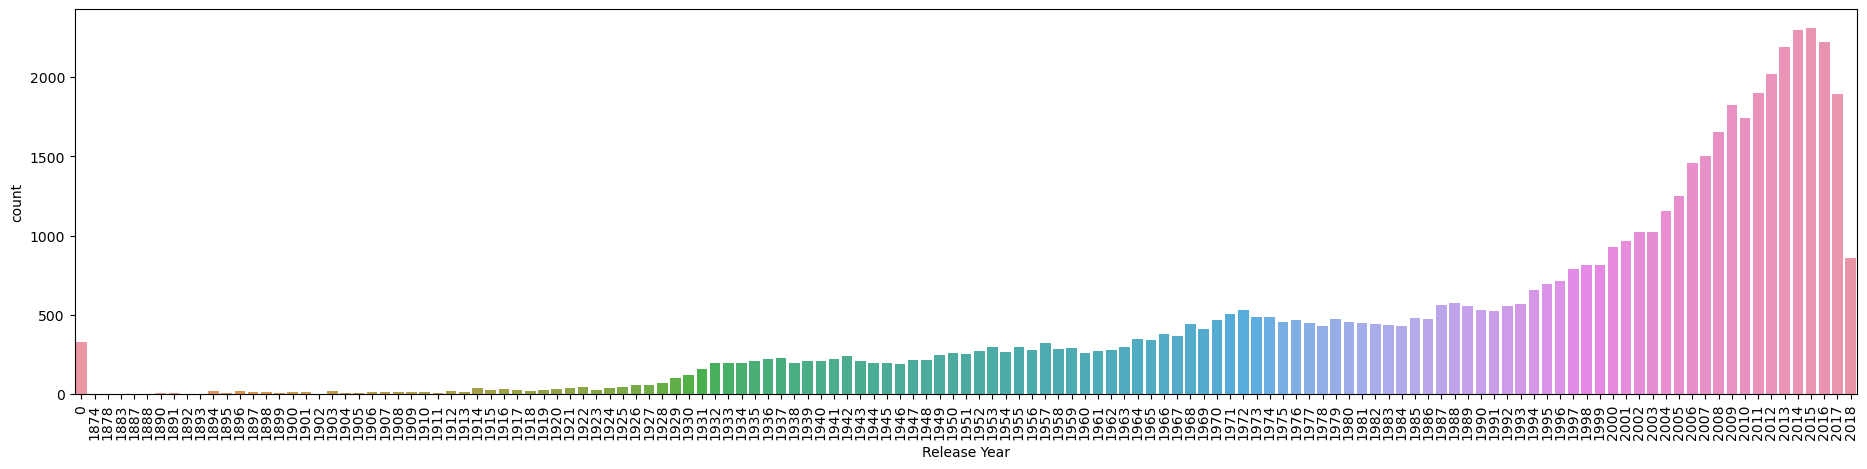

In [9]:
# visualize data using released date, 0 if no date specified
plt.subplots(figsize = (23,5))
sns.set_color_codes("pastel")
sns.countplot(x=genres_ds['Release Year']);
plt.xticks(rotation=90);

Too many unneccearily old movies so we can filter up to a more relevant year of 1990s

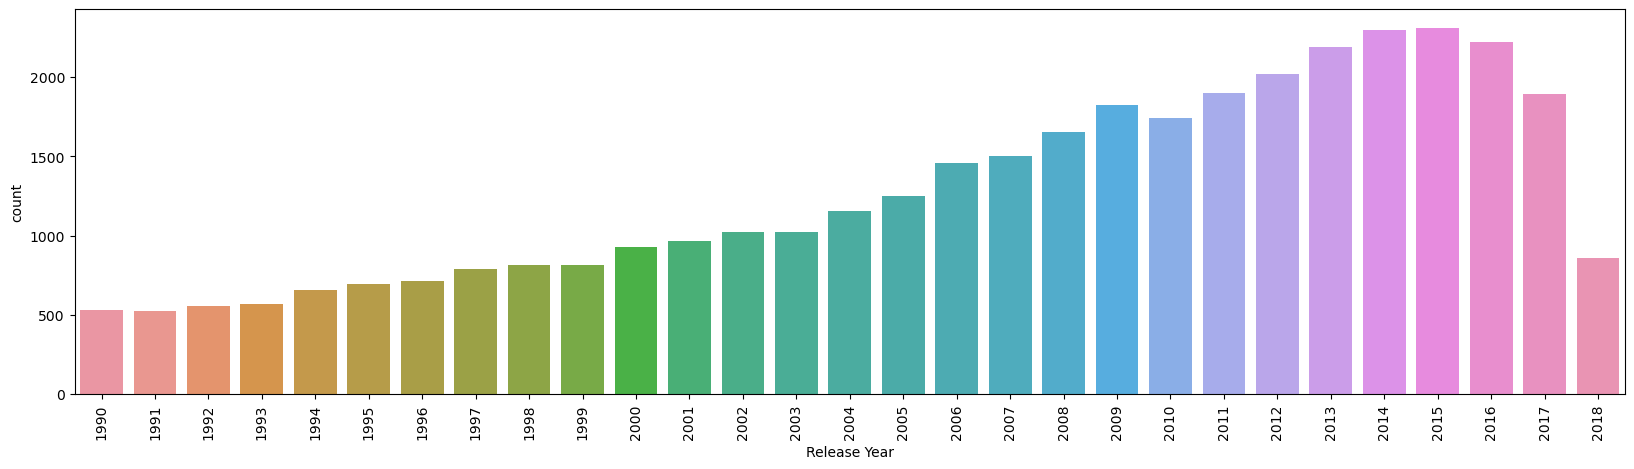

In [10]:
# filter out movies
filtered_mv = genres_ds.loc[(genres_ds['Release Year'] >= 1990) & (genres_ds['Release Year'] <= 2018)]

# visualize data using released date, 0 if no date specified
plt.subplots(figsize = (20,5))
sns.set_color_codes("pastel")
sns.countplot(x=filtered_mv['Release Year']);
plt.xticks(rotation=90);

In [11]:
# create binary indicators for each genre
genres_df_stack = filtered_mv[filtered_mv['genres'] != '(no genres listed)'].set_index('movieId').genres.str.split('|', expand = True).stack()
genres_df_explode = pd.get_dummies(genres_df_stack).groupby(level = 0).sum().reset_index()
del genres_df_stack

In [12]:
genres_df_explode

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34574,193872,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
34575,193878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34576,193880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
34577,193882,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [19]:
genres_df_explode['Release Year'] = filtered_mv['Release Year']

In [21]:
genres_df_explode = genres_df_explode[['movieId','Release Year', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary','Drama',"Fantasy",'Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']]

In [22]:
genres_df_explode

,movieId,Release Year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34574,193872,2015,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
34575,193878,2015,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34576,193880,1994,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
34577,193882,<NA>,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0


In [25]:
genres_df_explode.to_csv('item_vecs.csv',index=False)

In [13]:
ratings_ds.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [14]:
# calculate avg rating and count per movie
count_ratings = ratings_ds.groupby('movieId')['rating'].count()
average_ratings = ratings_ds.groupby('movieId')['rating'].mean().round(1)
ratings_counted = filtered_mv.merge(count_ratings, how='inner', on='movieId')
mv_ds= ratings_counted.merge(average_ratings, how='inner', on='movieId')
mv_ds.rename(columns={'rating_x':'rating_count', 'rating_y':'rating_avg'}, inplace=True)

In [15]:
mv_ds = mv_ds.dropna()

In [16]:
# rank it from highest rating count 
print(mv_ds[['movieId', 'Title', 'rating_count']].drop_duplicates().sort_values('rating_count', ascending=False))

       movieId                      Title  rating_count
310        318   The Shawshank Redemption         97999
347        356               Forrest Gump         97040
288        296               Pulp Fiction         92406
577        593   The Silence of the Lambs         87899
1758      2571                 The Matrix         84545
...        ...                        ...           ...
20462   140389                  Rose Hill             1
30811   177701         The Wyvern Mystery             1
20482   140463              I Spy Returns             1
20484   140467  The Facts of Life Reunion             1
17809   129715              Los Flamencos             1

[35619 rows x 3 columns]


In [17]:
mv_ds

,movieId,genres,Title,Release Year,rating_count,rating_avg
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,68469,3.9
1,2,Adventure|Children|Fantasy,Jumanji,1995,27143,3.2
2,3,Comedy|Romance,Grumpier Old Men,1995,15585,3.2
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995,2989,2.9
4,5,Comedy,Father of the Bride Part II,1995,15474,3.1
...,...,...,...,...,...,...
35614,193872,Drama,Room Laundering,2018,1,4.0
35615,193878,Comedy,Les tribulations d'une caissière,2011,1,2.0
35616,193880,Drama,Her Name Was Mumu,2016,1,2.0
35617,193882,Adventure|Drama|Horror|Sci-Fi,Flora,2017,1,2.0


In [18]:
mv_ds.to_csv('movie_content.csv')

In [18]:
# Create new genre dataframe for user training dataframe creation
genres_list = genres_ds[['movieId', 'genres']]
genres_list

,movieId,genres
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy
...,...,...
58093,193876,(no genres listed)
58094,193878,Comedy
58095,193880,Drama
58096,193882,Adventure|Drama|Horror|Sci-Fi


In [19]:
# drop genres first to add back new 
filtered_mv_no_g = filtered_mv.drop(columns='genres')

In [20]:
# merge new set of genre df and ratings df to start working on user df
merged_data = pd.merge(filtered_mv_no_g, ratings_ds, on='movieId')
merged_data_with_genres = pd.merge(merged_data, genres_list, on='movieId')

# split genre string by "|" and parse it as a list of genres in a genres column 
merged_data_with_genres['genres'] = merged_data_with_genres['genres'].str.split('|')

In [21]:
mv_ds

,movieId,genres,Title,Release Year,rating_count,rating_avg
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,68469,3.9
1,2,Adventure|Children|Fantasy,Jumanji,1995,27143,3.2
2,3,Comedy|Romance,Grumpier Old Men,1995,15585,3.2
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995,2989,2.9
4,5,Comedy,Father of the Bride Part II,1995,15474,3.1
...,...,...,...,...,...,...
35614,193872,Drama,Room Laundering,2018,1,4.0
35615,193878,Comedy,Les tribulations d'une caissière,2011,1,2.0
35616,193880,Drama,Her Name Was Mumu,2016,1,2.0
35617,193882,Adventure|Drama|Horror|Sci-Fi,Flora,2017,1,2.0


In [22]:
merged = merged_data_with_genres.sort_values(by='userId',ascending=True)

In [23]:
merged

,movieId,Title,Release Year,userId,rating,timestamp,genres
9458136,2840,Stigmata,1999,1,3.0,1256677500,"[Drama, Thriller]"
3732214,481,Kalifornia,1993,1,3.5,1256677456,"[Drama, Thriller]"
2305627,307,Three Colors: Blue,1993,1,3.5,1256677221,[Drama]
6786231,1591,Spawn,1997,1,1.5,1256677475,"[Action, Adventure, Sci-Fi, Thriller]"
10893029,3826,Hollow Man,2000,1,2.0,1256677210,"[Horror, Sci-Fi, Thriller]"
...,...,...,...,...,...,...,...
6758055,1584,Contact,1997,283228,4.0,1354159639,"[Drama, Sci-Fi]"
2740142,349,Clear and Present Danger,1994,283228,4.0,1354159688,"[Action, Crime, Drama, Thriller]"
356096,21,Get Shorty,1995,283228,4.0,1354159706,"[Comedy, Crime, Thriller]"
12388874,4995,A Beautiful Mind,2001,283228,4.0,1379882723,"[Drama, Romance]"


In [24]:
movies_needed = pd.DataFrame(mv_ds.movieId)

In [25]:
result = merged[merged['movieId'].isin(movies_needed['movieId'])]

In [26]:
result

,movieId,Title,Release Year,userId,rating,timestamp,genres
9458136,2840,Stigmata,1999,1,3.0,1256677500,"[Drama, Thriller]"
3732214,481,Kalifornia,1993,1,3.5,1256677456,"[Drama, Thriller]"
2305627,307,Three Colors: Blue,1993,1,3.5,1256677221,[Drama]
6786231,1591,Spawn,1997,1,1.5,1256677475,"[Action, Adventure, Sci-Fi, Thriller]"
10893029,3826,Hollow Man,2000,1,2.0,1256677210,"[Horror, Sci-Fi, Thriller]"
...,...,...,...,...,...,...,...
6758055,1584,Contact,1997,283228,4.0,1354159639,"[Drama, Sci-Fi]"
2740142,349,Clear and Present Danger,1994,283228,4.0,1354159688,"[Action, Crime, Drama, Thriller]"
356096,21,Get Shorty,1995,283228,4.0,1354159706,"[Comedy, Crime, Thriller]"
12388874,4995,A Beautiful Mind,2001,283228,4.0,1379882723,"[Drama, Romance]"


In [27]:
# Explode the genres column to create multiple rows for each genre
ratings = result.explode('genres')

# Pivot the table to get the average rating per genre per user
genre_ratings = pd.pivot_table(ratings, values='rating', index='userId', columns='genres', aggfunc='mean', fill_value=0).round(1)

# Get the count of ratings per user
user_ratings_count = ratings.groupby('userId').size().reset_index(name='rating_count')

# Merge the count of ratings per user with the genre ratings table
genre_ratings = pd.merge(genre_ratings, user_ratings_count, on='userId').reset_index()

In [28]:
genre_ratings

,index,userId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating_count
0,0,1,0.0,2.7,1.5,0.0,0.0,4.0,3.0,0.0,...,2.2,0.0,0.0,0.0,3.5,2.1,2.6,0.0,0.0,27
1,1,2,0.0,3.5,3.5,0.0,0.0,3.5,3.5,0.0,...,0.0,0.0,0.0,0.0,3.5,3.5,3.5,0.0,0.0,11
2,2,3,0.0,5.0,4.0,0.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,3.5,0.0,0.0,3.5,5.0,0.0,14
3,3,4,0.0,3.5,3.4,3.6,2.3,2.9,3.8,3.4,...,3.5,3.8,2.5,3.8,3.2,3.5,3.7,3.9,2.8,1688
4,4,5,0.0,4.3,4.3,0.0,0.0,4.3,4.3,4.5,...,0.0,4.0,0.0,4.3,4.5,4.5,4.2,4.3,4.5,178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281085,281085,283224,0.0,3.4,3.3,0.0,3.0,3.4,3.7,4.0,...,3.3,0.0,4.0,3.3,3.5,3.4,3.6,3.5,3.7,324
281086,281086,283225,0.0,2.8,2.5,0.0,0.0,3.1,3.4,0.0,...,0.0,0.0,0.0,3.0,3.1,2.5,2.8,2.5,3.5,41
281087,281087,283226,0.0,1.3,2.0,0.0,1.0,1.8,1.5,0.0,...,2.0,0.0,0.0,2.0,1.0,0.0,1.8,0.0,0.0,20
281088,281088,283227,0.0,4.5,3.8,2.5,4.2,3.7,3.9,0.0,...,0.0,0.0,0.0,0.0,4.2,0.0,4.7,0.0,4.5,30


In [29]:
final_res = genre_ratings.merge(result, how='inner', on='userId')

In [30]:
final_res.head()

,index,userId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Thriller,War,Western,rating_count,movieId,Title,Release Year,rating,timestamp,genres
0,0,1,0.0,2.7,1.5,0.0,0.0,4.0,3.0,0.0,...,2.6,0.0,0.0,27,2840,Stigmata,1999,3.0,1256677500,"[Drama, Thriller]"
1,0,1,0.0,2.7,1.5,0.0,0.0,4.0,3.0,0.0,...,2.6,0.0,0.0,27,481,Kalifornia,1993,3.5,1256677456,"[Drama, Thriller]"
2,0,1,0.0,2.7,1.5,0.0,0.0,4.0,3.0,0.0,...,2.6,0.0,0.0,27,307,Three Colors: Blue,1993,3.5,1256677221,[Drama]
3,0,1,0.0,2.7,1.5,0.0,0.0,4.0,3.0,0.0,...,2.6,0.0,0.0,27,1591,Spawn,1997,1.5,1256677475,"[Action, Adventure, Sci-Fi, Thriller]"
4,0,1,0.0,2.7,1.5,0.0,0.0,4.0,3.0,0.0,...,2.6,0.0,0.0,27,3826,Hollow Man,2000,2.0,1256677210,"[Horror, Sci-Fi, Thriller]"


In [31]:
final_res.shape

(20671689, 29)

In [39]:
y_train = pd.DataFrame(final_res.rating)

In [40]:
y_train.shape

(20671689, 1)

In [41]:
y_train[:5]

,rating
0,3.0
1,3.5
2,3.5
3,1.5
4,2.0


In [35]:
final_users = final_res.drop(['index','movieId','Release Year','Title','timestamp','genres','rating','rating_count'], axis=1)

In [36]:
final_items = final_res[['movieId', 'Release Year']]

In [37]:
final_items = final_items.merge(genres_df_explode, how='left', on='movieId')
final_items.head()

,movieId,Release Year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,2840,1999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,481,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,307,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1591,1997,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,3826,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [42]:
final_items.to_csv('final_movies.csv', index=False)
final_users.to_csv('final_users.csv', index=False)
y_train.to_csv('y_train.csv', index=False)